# Balanceo del *Dataset*

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

## Carga del *dataset* escalado

In [34]:
df = pd.read_csv("../datasets/chicago_crimes_and_stations_2024_processed_outliers_encoded_standardized.csv")

In [35]:
df.head()

,Beat,Ward,Community Area,Day_sin,Season_Spring,Season_Summer,Season_Winter,Day Time_Early Morning,Day Time_Morning,Day Time_Night,...,Location_Description_freq,FBI_Code_freq,Crime_District_freq,Nearest_Police_Station_District_freq,Nearest_Police_Station_District_Name_freq,X Coordinate_standardized,Y Coordinate_standardized,Latitude_standardized,Longitude_standardized,Distance Crime To Police Station_standardized
0,332,5,43,0.433884,0.0,0.0,1.0,0.0,0.0,1.0,...,0.193257,0.111507,0.051350,0.094726,0.094726,1.328311,-0.864290,-0.867868,1.227417,-0.383022
1,223,3,38,0.433884,0.0,0.0,1.0,0.0,0.0,1.0,...,0.193257,0.073407,0.050961,0.043381,0.043381,0.887060,-0.439408,-0.441960,0.745457,-0.367422
2,834,18,70,0.433884,0.0,0.0,1.0,0.0,0.0,1.0,...,0.004937,0.032340,0.067433,0.066395,0.066395,-1.204564,-1.090141,-1.083194,-0.775529,1.410839
3,321,20,42,0.433884,0.0,0.0,1.0,0.0,0.0,1.0,...,0.273356,0.111507,0.051350,0.094726,0.094726,1.176932,-0.832694,-0.835673,1.227417,-0.899786
4,2531,29,25,0.433884,0.0,0.0,1.0,0.0,0.0,1.0,...,0.054023,0.148988,0.051445,0.050088,0.050088,-1.715246,0.638166,0.643290,-1.877089,0.075496


## Funciones auxiliares

In [36]:
# Función para calcular la entropía de Shannon
def shannon_entropy(y):
    probs = y.value_counts(normalize=True)
    return -np.sum(probs * np.log2(probs))

In [37]:
# Función para graficar la distribución de la variable target
def plot(y):
    fig, axes = plt.subplots(figsize=(4, 4))
    sns.countplot(x=y, hue=y, palette="Set2", ax=axes)

    axes.set_xlabel("Arrested")
    axes.set_ylabel("Cantidad")
    axes.set_title(f"Distribución de la variable {target}")

    plt.tight_layout()
    plt.show()

In [38]:
# Evaluación del desbalance
def info(y):
    print("Proporción de clases:")
    print(y.value_counts(normalize=True))
    entropy = shannon_entropy(y)
    print("\nEntropía de Shannon:", entropy)
    plot(y)

## Preparación del *dataset*

Separamos el *dataset* en X (variables) y (*target*)

Proporción de clases:
Arrest_tag
0    0.863938
1    0.136062
Name: proportion, dtype: float64

Entropía de Shannon: 0.5738323105250455


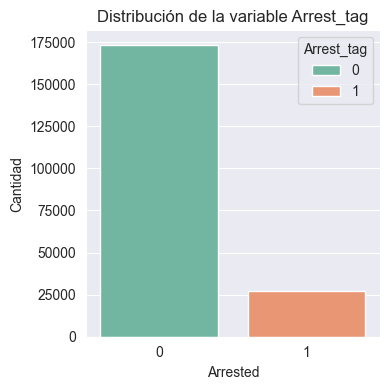

In [39]:
target = 'Arrest_tag'
X = df.drop(columns=[target])
y = df[target]

info(y) # datos originales

## Estrategia de balanceo

Si planteamos un problema de clasificación, teniendo como objetivo la variable “Arrest_tag”, se aprecia un gran desbalance (13.6% de la clase minoritaria '1').

Para abordar este problema en nuestro *dataset*, evaluamos varias estrategias.

### *Oversampling* con SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) busca igualar las clases creando muestras sintéticas de la clase minoritaria.

Proporción de clases:
Arrest_tag
0    0.5
1    0.5
Name: proportion, dtype: float64

Entropía de Shannon: 1.0


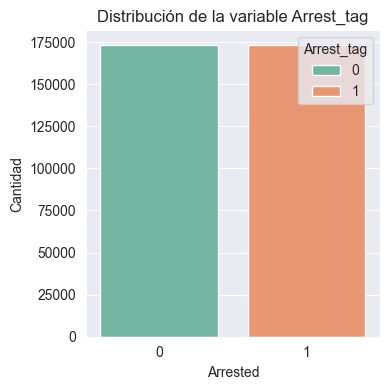

In [40]:
smote = SMOTE(random_state=17)
X_train_sm, y_train_sm = smote.fit_resample(X, y)
info(y_train_sm)

**Problema Principal:** Para lograr un balance 1:1, necesitaríamos generar cerca de 150.000 muestras sintéticas para la clase Arrest_tag=1. Confiar en un *dataset* donde la clase minoritaria está compuesta en su mayoría por datos "inventados" (interpolaciones) es arriesgado. El modelo podría sobreajustarse (*overfitting*) a estos patrones sintéticos, aprendiendo "atajos" que no existen en los datos reales. Esto haría que el modelo funcione bien en el entrenamiento, pero falle al predecir datos nuevos y reales.

In [41]:
# Guardamos el dataset de entrenamiento con oversampling (SMOTE)
df_smote = pd.concat([X_train_sm, y_train_sm], axis=1)
df_smote.to_csv("../datasets/chicago_crimes_and_stations_2024_processed_outliers_encoded_standardized_smote.csv", index=False)

### *Undersampling* con RandomUnderSampler

El submuestreo aleatorio (RandomUnderSampler) busca igualar las clases eliminando muestras de la clase mayoritaria.

Proporción de clases:
Arrest_tag
0    0.5
1    0.5
Name: proportion, dtype: float64

Entropía de Shannon: 1.0


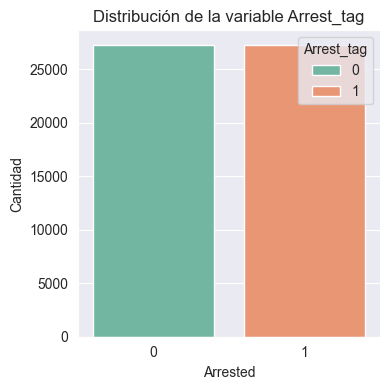

In [42]:
undersample = RandomUnderSampler(random_state=17)
X_train_us, y_train_us = undersample.fit_resample(X, y)
info(y_train_us)

**Problema Principal:** En nuestro caso, para lograr un balance 1:1, necesitaríamos eliminar cerca de 150.000 muestras de la clase Arrest_tag=0. Descartar una cantidad tan masiva de datos es peligroso. Estaríamos perdiendo una enorme cantidad de información, variabilidad y patrones que residen en la clase mayoritaria. Esto podría llevar a un modelo subajustado (*underfitting*), incapaz de generalizar porque no ha visto suficientes ejemplos de la complejidad real del problema.

In [43]:
# Guardamos el dataset de entrenamiento con undersampling
df_undersample = pd.concat([X_train_us, y_train_us], axis=1)
df_undersample.to_csv("../datasets/chicago_crimes_and_stations_2024_processed_outliers_encoded_standardized_undersample.csv", index=False)

### Estrategia Combinada

Decidimos implementar un *pipeline* que combina ambas técnicas de forma moderada, obteniendo "lo mejor de los dos mundos":

1. SMOTE (al 0.5): Primero, generamos una cantidad moderada de muestras sintéticas. No buscamos un balance 1:1, solo "reforzamos" la clase minoritaria para darle más presencia y patrones para que el modelo aprenda.
2. RandomUnderSampler (al 0.8): Segundo, reducimos moderadamente la clase mayoritaria. No la diezmamos, solo "limpiamos" su dominio para que no sea abrumadora y forzamos al modelo a prestar más atención a los casos minoritarios.

In [44]:
# Oversampling (SMOTE)
# sampling_strategy=0.5 significa que la clase minoritaria llegará a ser el 50%
# del tamaño de la clase mayoritaria original.
over = SMOTE(sampling_strategy=0.5, random_state=17)

In [45]:
# Undersampling
# sampling_strategy=0.8 significa que, después del undersampling, la clase minoritaria
# tendrá un tamaño equivalente al 80% de la clase mayoritaria.
under = RandomUnderSampler(sampling_strategy=0.8, random_state=17)

In [ ]:
# Creamos el Pipeline que combina ambos pasos
# El pipeline aplicará los pasos en el orden en que se definen.
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

Proporción de clases:
Arrest_tag
0    0.555555
1    0.444445
Name: proportion, dtype: float64

Entropía de Shannon: 0.991076243369027


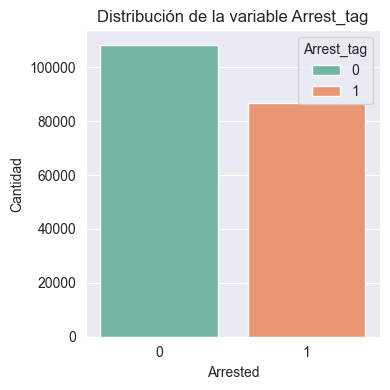

In [47]:
# Aplicar el pipeline a los datos de entrenamiento
X_resampled, y_resampled = pipeline.fit_resample(X, y)
info(y_resampled)

Esta estrategia combinada nos permite lograr el objetivo de que la proporción entre la clase minoritaria y la mayoritaria sea del 80% (aún se conservan una gran cantidad de datos totales, tanto reales como sintéticos). Esto nos permite afirmar que el *dataset* final es robusto y equilibrado.

**Beneficios:**

* Se mejora la capacidad del modelo para reconocer casos de arresto (clase 1).
* Se minimiza el riesgo de sobreajuste al utilizar *oversampling* puro.
* Se minimiza el riesgo de pérdida de información al utilizar *undersampling* puro.
* Se preserva la representatividad de los datos reales.


In [48]:
# Guardamos el dataset resultante
df_combined = pd.concat([X_resampled, y_resampled], axis=1)
df_combined.to_csv("../datasets/chicago_crimes_and_stations_2024_processed_outliers_encoded_standardized_combined.csv", index=False)